<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/NLP/Unsupervised_extractive_summarization_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Extractive Summarization with BERT
This notebook demonstrates EmbedRank, which is an unsupervised keyphrase extraction model [1]. Sentence embeddings obtained from Hugging Face's BERT are used to calculate each sentence's importance.


## Settings

In [1]:
#@title Setup Environment
!pip install --quiet googletrans==2.4.0
!pip install --quiet japanize-matplotlib==1.0.4
!pip install --quiet pytorch_transformers
!pip install --quiet mecab-python3
!pip install --quiet https://github.com/megagonlabs/ginza/releases/download/v1.0.2/ja_ginza_nopn-1.0.2.tgz
!pip install --quiet https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.1.0/en_core_web_sm-2.1.0.tar.gz
!ln -s /usr/local/lib/python3.6/dist-packages/ja_ginza_nopn /usr/local/lib/python3.6/dist-packages/spacy/data/ja_ginza_nopn

     |████████████████████████████████| 122.4MB 273kB/s 
     |████████████████████████████████| 11.1MB 1.6MB/s 


In [0]:
#@title Setup common imports and functions
from googletrans import Translator
import torch
from pytorch_transformers import (
    BertTokenizer,
    BertModel,
)
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import spacy
from IPython.display import HTML
from sklearn import manifold
from sklearn.metrics.pairwise import cosine_distances
%matplotlib inline


def ncossim(embs_1, embs_2, axis=0):
    sims = np.inner(embs_1, embs_2)
    std = np.std(sims, axis=axis)
    ex = np.mean((sims-np.min(sims, axis=axis))/np.max(sims, axis=axis), axis=axis)
    return 0.5 + (sims-ex)/std


def mmr(doc_emb, cand_embs, key_embs):
    param = 0.5
    scores = param * ncossim(cand_embs, doc_emb, axis=0)
    if key_embs is not None:
        scores -= (1-param) * np.max(ncossim(cand_embs, key_embs), axis=1).reshape(scores.shape[0], -1)
    return scores


def embedrank(doc_emb, sent_embs, n_keys):
    assert 0 < n_keys, 'Please `key_size` value set more than 0'
    assert n_keys < len(sent_embs), 'Please `key_size` value set lower than `#sentences`'
    sims = np.inner(doc_emb, sent_embs).reshape(-1)
    return np.argsort(-sims)[:n_keys]


def embedrankpp(doc_emb, sent_embs, n_keys):
    assert 0 < n_keys, 'Please `key_size` value set more than 0'
    assert n_keys < len(sent_embs), 'Please `key_size` value set lower than `#sentences`'
    cand_idx = list(range(len(sent_embs)))
    key_idx = []
    while len(key_idx) < n_keys:
        cand_embs = sent_embs[cand_idx]
        key_embs = sent_embs[key_idx] if len(key_idx) > 0 else None
        scores = mmr(doc_emb, cand_embs, key_embs)
        key_idx.append(cand_idx[np.argmax(scores)])
        cand_idx.pop(np.argmax(scores))
    return key_idx

## Extractive Summarization

In [0]:
# Document from Wikipedia
doc = """500+ Words Essay on Sachin Tendulkar.
We have often heard that ‘Cricket is religion in India and Sachin is God’. 
There is no better statement that can justify the status of Sachin Tendulkar in India. 
Sachin Tendulkar in India is not just a cricketer, he is God. Also for common people in India, he is an example of hard work and determination. 
Thus, he is worshipped by everyone in India. The essay on Sachin Tendulkar is a small insight into one of the greatest ever sportsman to have played any game. 
Sachin Tendulkar was born to a middle-class family and came to limelight with a performance in the school tournament. 
He held a record partnership at that time with Vinod Kambli playing for their school tournament. 
That innings changed Sachin’s life completely and he became famous in a fortnight. 
In those days, the school tournaments had a different fanbase and a good performance can bring you in limelight. 
Because of that inning, people all over India came to know who Sachin Tendulkar was! 
Thus, it also caught Indian selector’s eye and Sachin Tendulkar was selected for the tour of Pakistan at an age of 16!  

At 16 years of age, Sachin was supposed to face the likes of Wasim Akram and Waqar Younis. The Pakistani spearheads were known for their swing and sharp bouncers. 
Thus, Sachin had a hard time facing Pakistan fast bowlers. Still, he managed to come out with some runs under his belt. 
Thus, it would justify the Sachin’s selection in the series to come. The series was a memorable experience for Sachin as he also got to spend time with his idols in the Indian dressing room. 
Sachin Tendulkar – The Opener. 
The real contribution by Sachin Tendulkar to Indian cricket is not the runs he scored or the matches he won. 
The main contribution by Sachin was the way he changed the opening in ODI cricket. 
He was given an opportunity to open against New Zealand in New Zealand in 1992 and he made it count. 
Thus, a very different dimension of Sachin Tendulkar came into light. The major contribution of runs scored by him in ODI cricket is by opening the batting for India. 
Thus, India got one of the reliable openers in Sachin who can also score at more than run a ball.  
"""

In [18]:
#@title Language detection and sentence segmentation
translator = Translator()
detected_lang = translator.detect(doc)

assert detected_lang.lang in ['ja', 'en'], 'Please, input Japanese text or English text'
if detected_lang.lang == 'ja':
    sentence_splitter = spacy.load('ja_ginza_nopn')
elif detected_lang.lang == 'en':
    sentence_splitter = spacy.load('en_core_web_sm')

sents = [str(s) for s in sentence_splitter(doc.replace('\n', '')).sents]
print(f'Language: {detected_lang.lang}')
print(f'#sentences: {len(sents)}')

Language: en
#sentences: 28


In [0]:
#@title Build a model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertModel.from_pretrained('bert-base-multilingual-cased')
rank_fn = embedrankpp

In [0]:
CUDA_LAUNCH_BLOCKING=1

In [0]:
#@title Model run
# Convert tokens into ids
encoded_doc = torch.tensor(tokenizer.encode(doc)).unsqueeze(0)
encoded_sents = [tokenizer.encode(s) for s in sents]
pad_idx = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
maxlen = max([len(s) for s in encoded_sents])
encoded_sents = torch.tensor([s + [pad_idx for _ in range(maxlen-len(s))] for s in encoded_sents])

if torch.cuda.is_available:
    model.to('cuda')
    encoded_doc = encoded_doc.to('cuda')
    encoded_sents = encoded_sents.to('cuda')
    
# Encode
doc_emb = torch.mean(model(encoded_doc)[0], dim=1).to('cpu').detach().numpy()
sent_embs = torch.mean(model(encoded_sents)[0], dim=1).to('cpu').detach().numpy()

# Ranking
key_size = 3 #@param {type:"integer"}
keys = rank_fn(doc_emb, sent_embs, key_size)

In [22]:
#@title Display
display_sents = []
for i, s in enumerate(sents):
    line = '<font color="#CD5C5C"><strong>' + s + '</strong></font>' if i in keys else s
    display_sents.append(line)
HTML(''.join(display_sents))

id	sentence
1	500+ Words Essay on Sachin Tendulkar.
2	We have often heard that ‘Cricket is religion in I...
3	There is no better statement that can justify the ...
4	Sachin Tendulkar in India is not just a cricketer,...
5	Also for common people in India, he is an example ...
6	Thus, he is worshipped by everyone in India.
7	The essay on Sachin Tendulkar is a small insight i...
8	Sachin Tendulkar was born to a middle-class family...
9	He held a record partnership at that time with Vin...
10	That innings changed Sachin’s life completely and ...
11	In those days, the school tournaments had a differ...
12	Because of that inning, people all over India came...
13	Thus, it also caught Indian selector’s eye
14	and Sachin Tendulkar was selected for the tour of ...
15	At 16 years of age, Sachin was supposed to face th...
16	The Pakistani spearheads were known for their swin...
17	Thus, Sachin had a hard time facing Pakistan fast ...
18	Still, he managed to come out with some runs under...
19	Thus

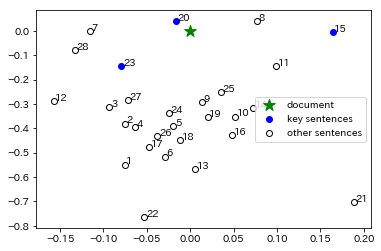

In [23]:
#@title Visualize sentence embeddings
# print sentences
print('id' + '\t' + 'sentence')
for i, sent in enumerate(sents, 1):
    if len(sent) < 50:
        print(str(i) + '\t' + sent)
    else:
        print(str(i) + '\t' + sent[:50] + '...')
print('')

# MDS
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")
embs = np.concatenate((doc_emb, sent_embs), 0)
dist_matrix = cosine_distances(embs, embs)
pns = mds.fit_transform(dist_matrix)
fixed_pns = pns - pns[0]
# plot
keys_idx = [idx + 1 for idx in keys]
other_idx = [idx for idx in range(1, len(sents)+1) if idx not in keys_idx]
plt.scatter(fixed_pns[0,0], fixed_pns[0,1], color='green',  marker='*', s=150, label='document')
plt.scatter(fixed_pns[keys_idx,0], fixed_pns[keys_idx, 1], color='blue', label='key sentences')
plt.scatter(fixed_pns[other_idx,0], fixed_pns[other_idx, 1], color='white', edgecolors='black', label='other sentences')

for i,(x,y) in enumerate(fixed_pns[1:], 1):
    plt.annotate(str(i), (x+0.002 ,y+0.002))
    
plt.legend()
plt.show()


## References
1. [Kamil Bennani-Smires, Claudiu Musat, Andreaa Hossmann, Michael Baeriswyl, Martin Jaggi. Simple Unsupervised Keyphrase Extraction using Sentence Embeddings. CoNLL 2018, pages 221–229](https://www.aclweb.org/anthology/K18-1022)


